In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#### Importing and preparing the data

In [108]:
# Read the data from CSV file
newData = pd.read_csv("Office_Garman.csv", index_col="timestamp", parse_dates=True)
# Remove duplicate entries
newData = newData.drop_duplicates()
# Set the frequency to hourly
newData = newData.asfreq('H')
# Fill missing values using forward fill method
newData = newData.fillna(method='ffill')

#### Visualizing the data

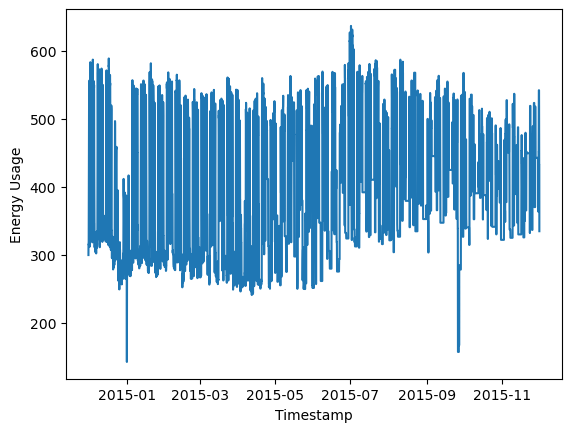

In [109]:
plt.plot(newData)
plt.xlabel('Timestamp')
plt.ylabel('Energy Usage')
plt.show()

####

#### Splitting the data for training and testing

In [110]:
# Define the split date
split_date = '2015-09-30'

# Split the data into training and testing sets
train = newData.loc[:split_date]
test = newData.loc[split_date:]


#### Plotting the ACF and PACF

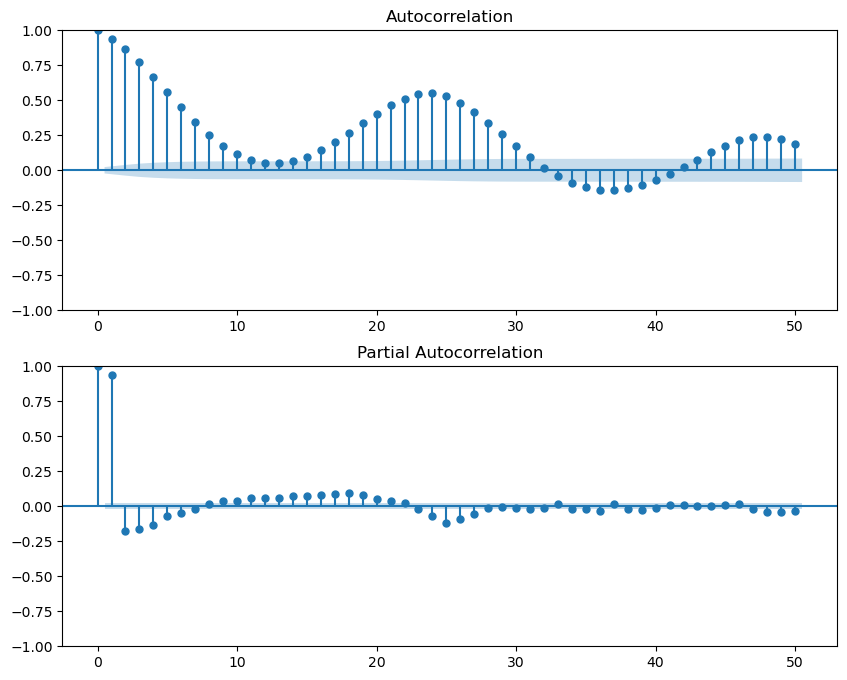

In [111]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(train, ax=ax1, lags=50)
plot_pacf(train, ax=ax2, lags=50)
plt.show()

#### Performing seasonal differencing for 24 hours

In [112]:
#differenced_data = newData['Office_Garman'].diff(24).dropna()
#train_diff = differenced_data.loc[:split_date]
#test_diff = differenced_data.loc[split_date:]

#### Plotting the ACF and PACF to the differenced data

In [113]:
#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
#plot_acf(train_diff, ax=ax1, lags=50)
#plot_pacf(train_diff, ax=ax2, lags=50)
#plt.show()

#### Deciding the order of the p,d,q using auto_arima function

In [114]:
from pmdarima import auto_arima
#stepwise_fit = auto_arima(train_diff, trace=True,
#suppress_warnings=True, max_p=24, max_q=24)

stepwise_fit = auto_arima(train, start_p=1, start_q=1,
                      test='adf',
                      max_p=24, max_q=24,
                      m=1,             
                      d=1,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=71237.907, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=71483.157, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=71332.660, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=71360.346, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71481.158, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=71218.470, Time=1.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=71242.926, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=71206.130, Time=1.60 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=71204.132, Time=0.33 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=71206.130, Time=0.39 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=71208.111, Time=0.94 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=71202.132, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=71240.926, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=71204.130, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0

#### Fitting the ARIMA model

In [121]:
from statsmodels.tsa.arima.model import ARIMA

# Fitting the ARIMA model
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()

# Printing the summary
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Office_Garman   No. Observations:                 7296
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -35595.232
Date:                Mon, 22 May 2023   AIC                          71202.464
Time:                        11:40:52   BIC                          71243.834
Sample:                    12-01-2014   HQIC                         71216.690
                         - 09-30-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1194      0.014      8.576      0.000       0.092       0.147
ar.L2          0.1039      0.012      8.414      0.000       0.080       0.128
ar.L3          0.0769      0.011      6.937      0.000       0.055       0.099
ar.L4          0.0032      0.014      0.235      0.815      -0.023       0.030
ar.L5         -0.0224      0.015     -1.463      0.143      -0.052       0.008
sigma2      1013.9017      5.618    180.484      0.000    1002.891    1024.912
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             78981.49
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                             1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Evaluating the residuals

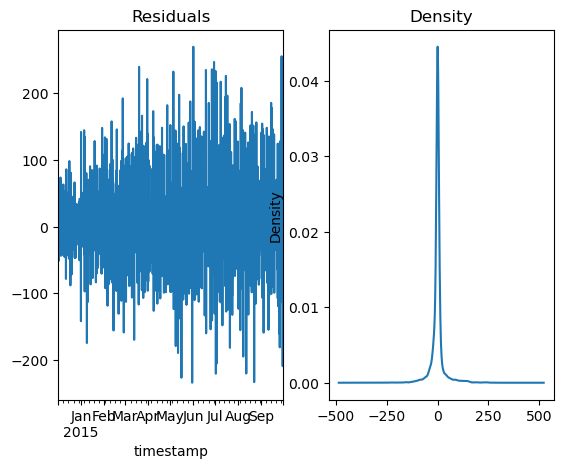

In [122]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

#### Predicting on the test set

In [123]:
# Make predictions on the test set
predictions = model_fit.predict(start=test.index[0], end=test.index[-1])

# Display the predictions
print(predictions)


2015-09-30 00:00:00    301.203326
2015-09-30 01:00:00    304.452838
2015-09-30 02:00:00    310.097975
2015-09-30 03:00:00    325.535046
2015-09-30 04:00:00    330.891063
                          ...    
2015-11-30 19:00:00    339.664934
2015-11-30 20:00:00    339.664934
2015-11-30 21:00:00    339.664934
2015-11-30 22:00:00    339.664934
2015-11-30 23:00:00    339.664934
Freq: H, Name: predicted_mean, Length: 1488, dtype: float64


#### Plotting the predictions and actual data

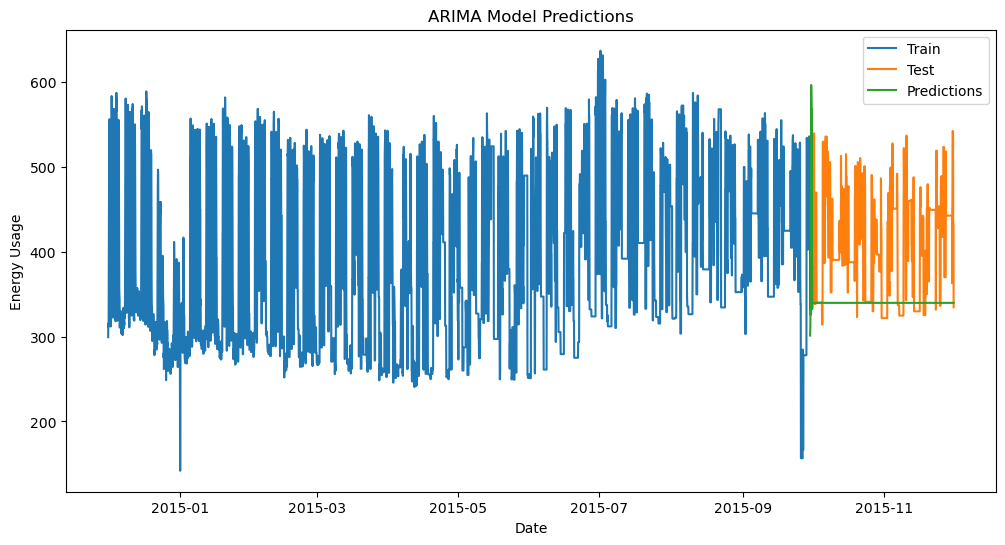

In [124]:
# Import the required libraries
import matplotlib.pyplot as plt

# Plotting the actual data and predictions
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='Train')
plt.plot(test.index, test.values, label='Test')
plt.plot(predictions.index, predictions.values, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Energy Usage')
plt.title('ARIMA Model Predictions')
plt.legend()
plt.show()


#### Evaluating the model predictions

In [125]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 71.48519911553662
mape - manual: 0.1596737061957656
rmse - manual: 90.58836832194032
